# Oct 15-16,21-25, 2023: overlapping communities: runwise: hierarchical bootstrapping of memberships

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product, permutations
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
from sympy.utilities.iterables import multiset_permutations
from sklearn.cluster import KMeans

# networks
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
import ants
from nipype.interfaces import afni

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

In [3]:
args.num_subs = 10
args.num_sess = 3
args.num_rois = 686
args.percentile = 90
args.num_comms = 5
args.num_resamples = 1000


BASE_path = f'/home/govindas/mouse_dataset/roi'
FC_path = f'{BASE_path}/func_nws_files'
COMM_path = f'{BASE_path}/svinet_folders/k{args.num_comms}'

---

In [4]:
# folders ordered hierarchically
def get_main_sample(args):
    main_sample = [
        [
            []
            for ses in range(args.num_sess)
        ]
        for sub in range(args.num_subs)
    ]
    for folder in os.listdir(COMM_path):
        fs = folder.split('_')
        if int(fs[2].split('-')[-1]) % 2 == 0: continue # skip even runs
        sub = int(fs[0].split('-')[-1][-2:])
        ses = int(fs[1].split('-')[-1])
        # run = int(fs[2].split('-')[-1])
        main_sample[sub-1][ses-1].append(folder)

    for sub in np.arange(1,args.num_subs+1):
        for ses in np.arange(1, args.num_sess+1):
            main_sample[sub-1][ses-1] = list(np.sort(main_sample[sub-1][ses-1]))
    return main_sample

In [5]:
def get_main_groups(args, main_sample):
    # collect community (a.k.a. group) memberships
    groups_sample = [
        [
            []
            for ses in range(args.num_sess)
        ]
        for sub in range(args.num_subs)
    ]
    for sub in range(args.num_subs):
        for ses in range(args.num_sess):
            for run in main_sample[sub][ses]:
                groups_file = [file for file in os.listdir(f'{COMM_path}/{run}') if 'groups.txt' in file][0]
                groups_file = f'{COMM_path}/{run}/{groups_file}'
                gs_ = np.loadtxt(groups_file)
                groups = np.zeros((args.num_rois, args.num_comms))
                groups[gs_[:, 1].astype(int), :] = gs_[:, 2:]
                groups_sample[sub][ses].append(groups)   
    return groups_sample

In [6]:
def align_two_groups(args, groups1, groups2):
    best_sim = -1
    best_pi = np.arange(args.num_comms)
    for perm in multiset_permutations(np.arange(args.num_comms)):
        pi = np.array(perm)
        perm_groups2 = groups2[:,pi]
        curr_sim = np.corrcoef(groups1.flatten(),perm_groups2.flatten())[0,1]
        if curr_sim > best_sim:
            best_sim = curr_sim
            best_pi = pi
    return groups2[:, best_pi], best_pi,

def align_groups(args, groups_sample):
    groups1 = groups_sample[0][0][0]
    for idx_sub, sub in enumerate(groups_sample):
        for idx_ses, ses in enumerate(sub):
            for idx_run, run in enumerate(ses):
                (
                    run, 
                    best_pi,
                ) = align_two_groups(args, groups1, run)
                groups_sample[idx_sub][idx_ses][idx_run] = run
                # print(idx_sub, idx_ses, idx_run, best_pi)
    return groups_sample

In [7]:
def resample(args, groups_main_sample):
    subs = groups_main_sample
    groups_resample = [[] for _ in range(len(subs))]
    for idx_sub, sub in enumerate(
        np.random.choice(
            np.arange(1, len(subs)+1), 
            size=len(subs), replace=True
        )
    ):
        sess = groups_main_sample[sub-1]
        groups_resample[idx_sub] = [[] for _ in range(len(sess))]
        for idx_ses, ses in enumerate(
            np.random.choice(
                np.arange(1, len(sess)+1), 
                size=len(sess)
            )
        ):
            runs = groups_main_sample[sub-1][ses-1]
            groups_resample[idx_sub][idx_ses] = [None for _ in range(len(runs))]
            for idx_run, run in enumerate(
                np.random.choice(
                    np.arange(1, len(runs)+1),
                    size=len(runs)
                )
            ):
                groups_resample[idx_sub][idx_ses][idx_run] = runs[run-1]
    return groups_resample

In [8]:
def sample_mean(args, groups_sample):
    groups = []
    for sub in groups_sample:
        for ses in sub:
            for run in ses:
                groups.append(run)
    return np.mean(groups, axis=0)

100%|██████████| 1000/1000 [00:01<00:00, 745.83it/s]


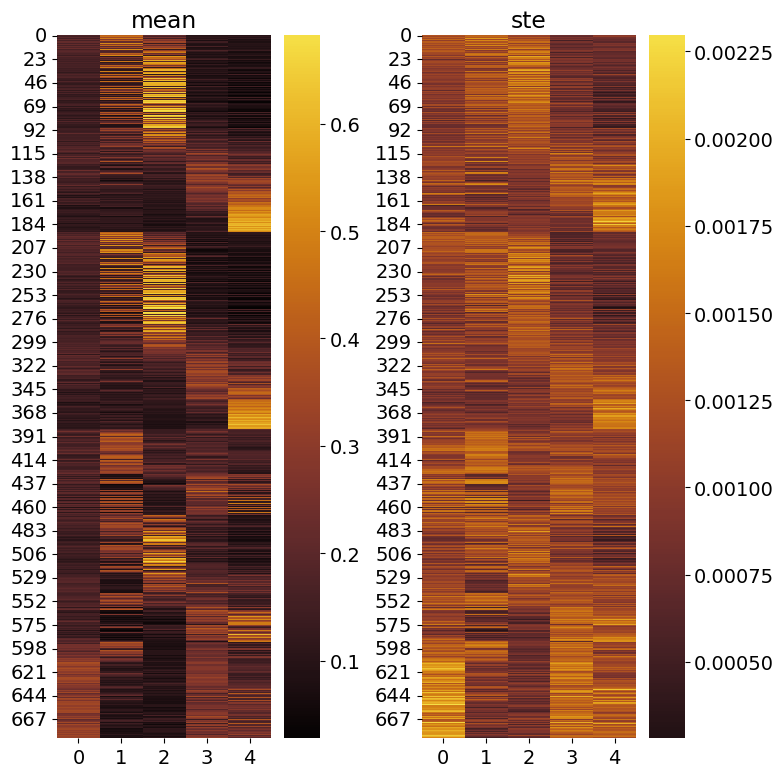

In [9]:
main_sample = get_main_sample(args)
groups_main_sample = get_main_groups(args, main_sample)
groups_main_sample= align_groups(args, groups_main_sample)

groups = []
for idx in tqdm(np.arange(args.num_resamples)):
    groups_resample = resample(args, groups_main_sample)
    groups_sample_mean = sample_mean(args, groups_resample)
    groups.append(groups_sample_mean)

groups_mean = np.mean(groups, axis=0)
groups_ste = np.std(groups, axis=0) / np.sqrt(len(groups))

fig, axs = plt.subplots(1, 2, figsize=(8, 8))
sns.heatmap(groups_mean, ax=axs[0], cbar=True, cmap=cmr.iceburn, center=0)
axs[0].set_title('mean')
sns.heatmap(groups_ste, ax=axs[1], cbar=True, cmap=cmr.iceburn, center=0)
axs[1].set_title('ste')
fig.tight_layout()

In [10]:
with open(f'{BASE_path}/estimates/hierarch_boot_mean_ste.pkl', 'wb') as f:
    pickle.dump([groups_mean, groups_ste], f)

with open(f'{BASE_path}/estimates/hierarch_boot_mean_ste.pkl', 'rb') as f:
    groups_mean, groups_ste = pickle.load(f)

---

In [11]:
parcels_img = ants.image_read(
    (
        f'/home/govindas/mouse_dataset'
        f'/allen_atlas_ccfv3/hadi/parcellation'
        f'/warped_on_n162/parcels_warped_cm.nii.gz'
    )
)
parcels = parcels_img.numpy()

roi_labels = np.loadtxt(
    (
        f'/home/govindas/mouse_dataset'
        f'/allen_atlas_ccfv3/hadi/parcellation'
        f'/warped_on_n162/roi_labels.txt'
    )
)

In [12]:
for comm in range(args.num_comms):
    groups_img = np.zeros_like(parcels)
    for idx, roi in enumerate(roi_labels.astype(int)):
        groups_img += (parcels == roi) * groups_mean[idx, comm]

    parcels_img.new_image_like(
        groups_img
    ).to_filename(f'{BASE_path}/estimates/hierarch_boot_mean_comm{comm}.nii.gz')

In [13]:
try:
    os.remove(f'{BASE_path}/estimates/hierarch_boot_mean_k{args.num_comms}.nii.gz')
except:
    pass

tcat = afni.TCat()
tcat.inputs.in_files = [
    f'{BASE_path}/estimates/hierarch_boot_mean_comm{comm}.nii.gz'
    for comm in range(args.num_comms)
]
tcat.inputs.out_file = f'{BASE_path}/estimates/hierarch_boot_mean_k{args.num_comms}.nii.gz'
tcat.inputs.rlt = ''
tcat.cmdline
res = tcat.run()

231030-16:10:38,996 nipype.interface INFO:
	 stderr 2023-10-30T16:10:38.996492:++ 3dTcat: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
231030-16:10:38,999 nipype.interface INFO:
	 stderr 2023-10-30T16:10:38.999471:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
231030-16:10:39,0 nipype.interface INFO:
	 stderr 2023-10-30T16:10:38.999471:*+ WARNING: Set TR of output dataset to 1.0 s
231030-16:10:39,56 nipype.interface INFO:
	 stderr 2023-10-30T16:10:39.056493:++ elapsed time = 0.1 s


---

In [14]:
groups_main_entropy = [
    [
        []
        for ses in range(args.num_sess)
    ]
    for sub in range(args.num_subs)
]
base = 2
for sub in range(args.num_subs):
    for ses in range(args.num_sess):
        for run in groups_main_sample[sub][ses]:
            groups_main_entropy[sub][ses].append(stats.entropy(run, base=base, axis=1))

Text(0.5, 1.0, 'entropy')

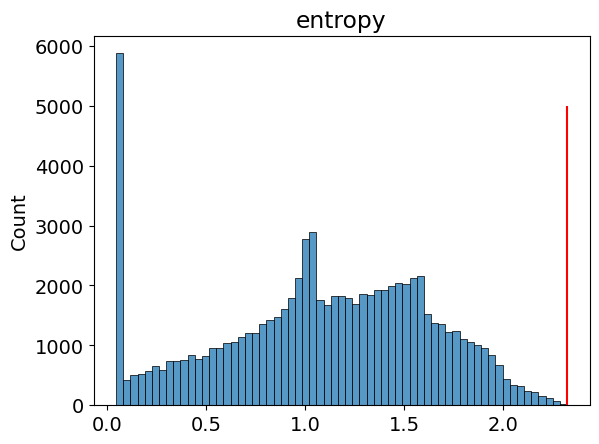

In [15]:
es = []
for sub in groups_main_entropy:
    for ses in sub:
        for run in ses:
            es.append(run)
sns.histplot(np.concatenate(es))
plt.vlines(np.log2(5), 0, 5000, colors='red')
plt.title('entropy')

---